In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


In [2]:
#라벨링 잔뜩
def encode_and_transform_dates(df):
    # 1. 라벨 인코딩할 열들 지정
    label_cols = ['Card Brand', 'Card Type', 'Error Message', 'Is Fraud?']
    
    # 2. 각 열에 대해 라벨 인코딩 수행
    label_encoders = {}
    for col in label_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # 나중에 필요하면 인코더 저장 (복원할 때 사용 가능)
    
    # 3. 날짜 데이터를 8자리 숫자로 변환
    # 'Expires' 변환 (MM/YYYY -> YYYYMMDD)
    df['Expires'] = df['Expires'].apply(lambda x: x.split('/')[1] + x.split('/')[0] + '01')
    
    # 'Acct Open Date' 변환 (MM/YYYY -> YYYYMMDD)
    df['Acct Open Date'] = df['Acct Open Date'].apply(lambda x: x.split('/')[1] + x.split('/')[0] + '01')
    
    # 날짜 형식을 int 타입으로 변환
    df['Expires'] = df['Expires'].astype(int)
    df['Acct Open Date'] = df['Acct Open Date'].astype(int)
    
    # 인코딩된 데이터프레임 반환
    return df


#Is Fraud : Yes-1, No-0으로 Labeled


In [3]:
def correlation_write(df, path='../datas/파생/correlation_matrix.csv'):
    # 상관관계 계산
    correlation_matrix = df.corr()
    
    # 상관관계 결과를 CSV로 저장
    correlation_matrix.to_csv(path)
    
    # 히트맵 그리기
    plt.figure(figsize=(10, 8)) 
    plt.title("Correlation Heatmap", fontsize=16)
    
    # Seaborn 히트맵 사용 (각 칸에 상관계수 표시)
    sns.heatmap(
        correlation_matrix, 
        annot=True,          # 상관계수 표시
        cmap='coolwarm', 
        linewidths=0.5, 
        fmt=".2f",           # 소수점 둘째 자리까지 표시
        annot_kws={"size": 10} # 상관계수 숫자의 글꼴 크기 지정
    )

    plt.tight_layout()
    plt.show()


---
---
---
#### 데이터 불러오기

Index(['User', 'Gender', 'Current Age', 'Retirement Age', 'Birth Year',
       'Birth Month', 'Zipcode', 'Per Capita Income - Zipcode',
       'Yearly Income', 'Total Debt', 'Credit Score', 'Year', 'Month', 'Day',
       'Merchandise Code', 'Card', 'Card Brand', 'Card Type', 'Card Number',
       'Expires', 'Has Chip', 'Credit Limit', 'Acct Open Date',
       'Year PIN last Changed', 'Amount', 'Whether Security Chip is Used',
       'Error Message', 'Is Fraud?'],
      dtype='object')


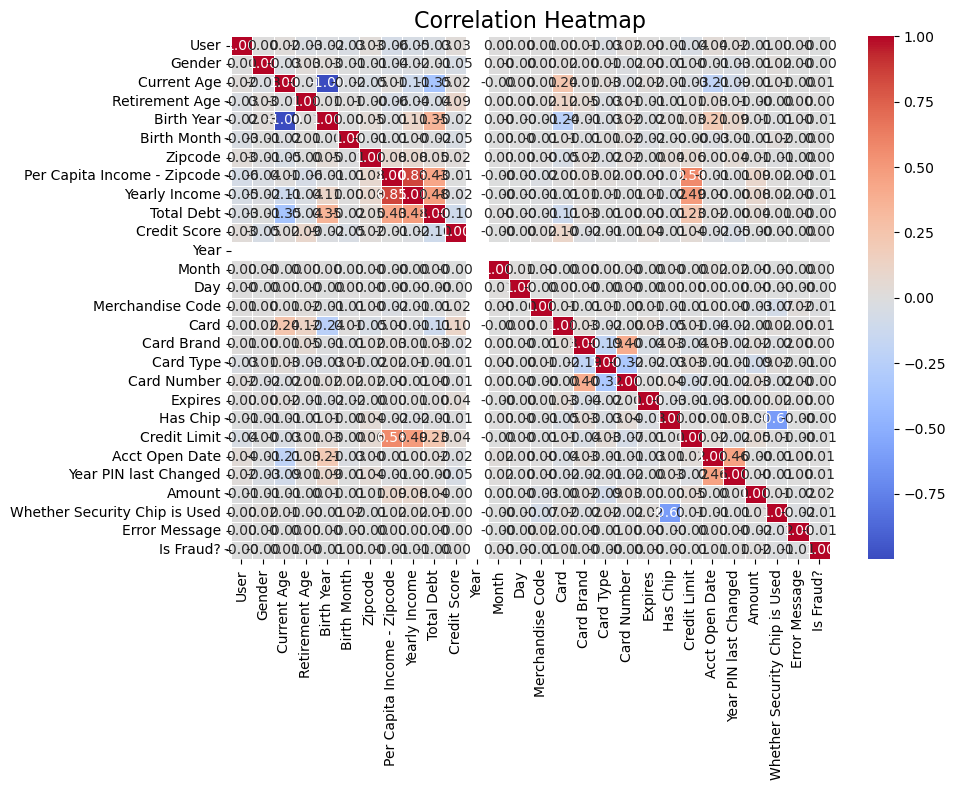

In [4]:
train_data = pd.read_csv('../datas/train.csv')
encode_and_transform_dates(train_data)
print(train_data.columns)
correlation_write(train_data)

#### 파생변수 생성
account open date / credit limit  
account open date / per capital income  
credit score/ user  
security chip used/ has chip-> 경우의 수에 대한 라벨링  
account pin changed/ security used  
  
credit score/ credit limit  
has chip/ pin last changed  
retirement age/ current age  
yearly income/ debt  

In [5]:
#아직 은퇴 안했으면 0, 했으면 한지 몇년됐는지

train_data['after retirement'] = np.where(
    train_data['Current Age'] > train_data['Retirement Age'], 
    train_data['Current Age'] - train_data['Retirement Age'], 
    0
)
# 부채 대비 소득 비율
train_data['DTI'] = train_data['Total Debt'] / train_data['Yearly Income']

# 신용 리스크
train_data['CRI'] = (train_data['Credit Limit'] / train_data['Credit Score']) * 100

# 지역에서 얼마나 잘사는지
train_data['buza'] = train_data['Yearly Income']/train_data['Per Capita Income - Zipcode']
train_data['buza'] = train_data['buza'].replace([np.inf,-np.inf],np.nan)
train_data['buza'] = train_data['buza'].fillna(train_data['buza'].mean())
train_data['buza'].to_csv('buza.csv')
print(np.isinf(train_data['buza']).any().any())

#같은 상품 내에서의 outlier
merchandise_mean = train_data.groupby('Merchandise Code')['Amount'].transform('mean')
train_data['Amount Diffenrece from Mean per Merchandise Code'] = train_data['Amount']-merchandise_mean



False


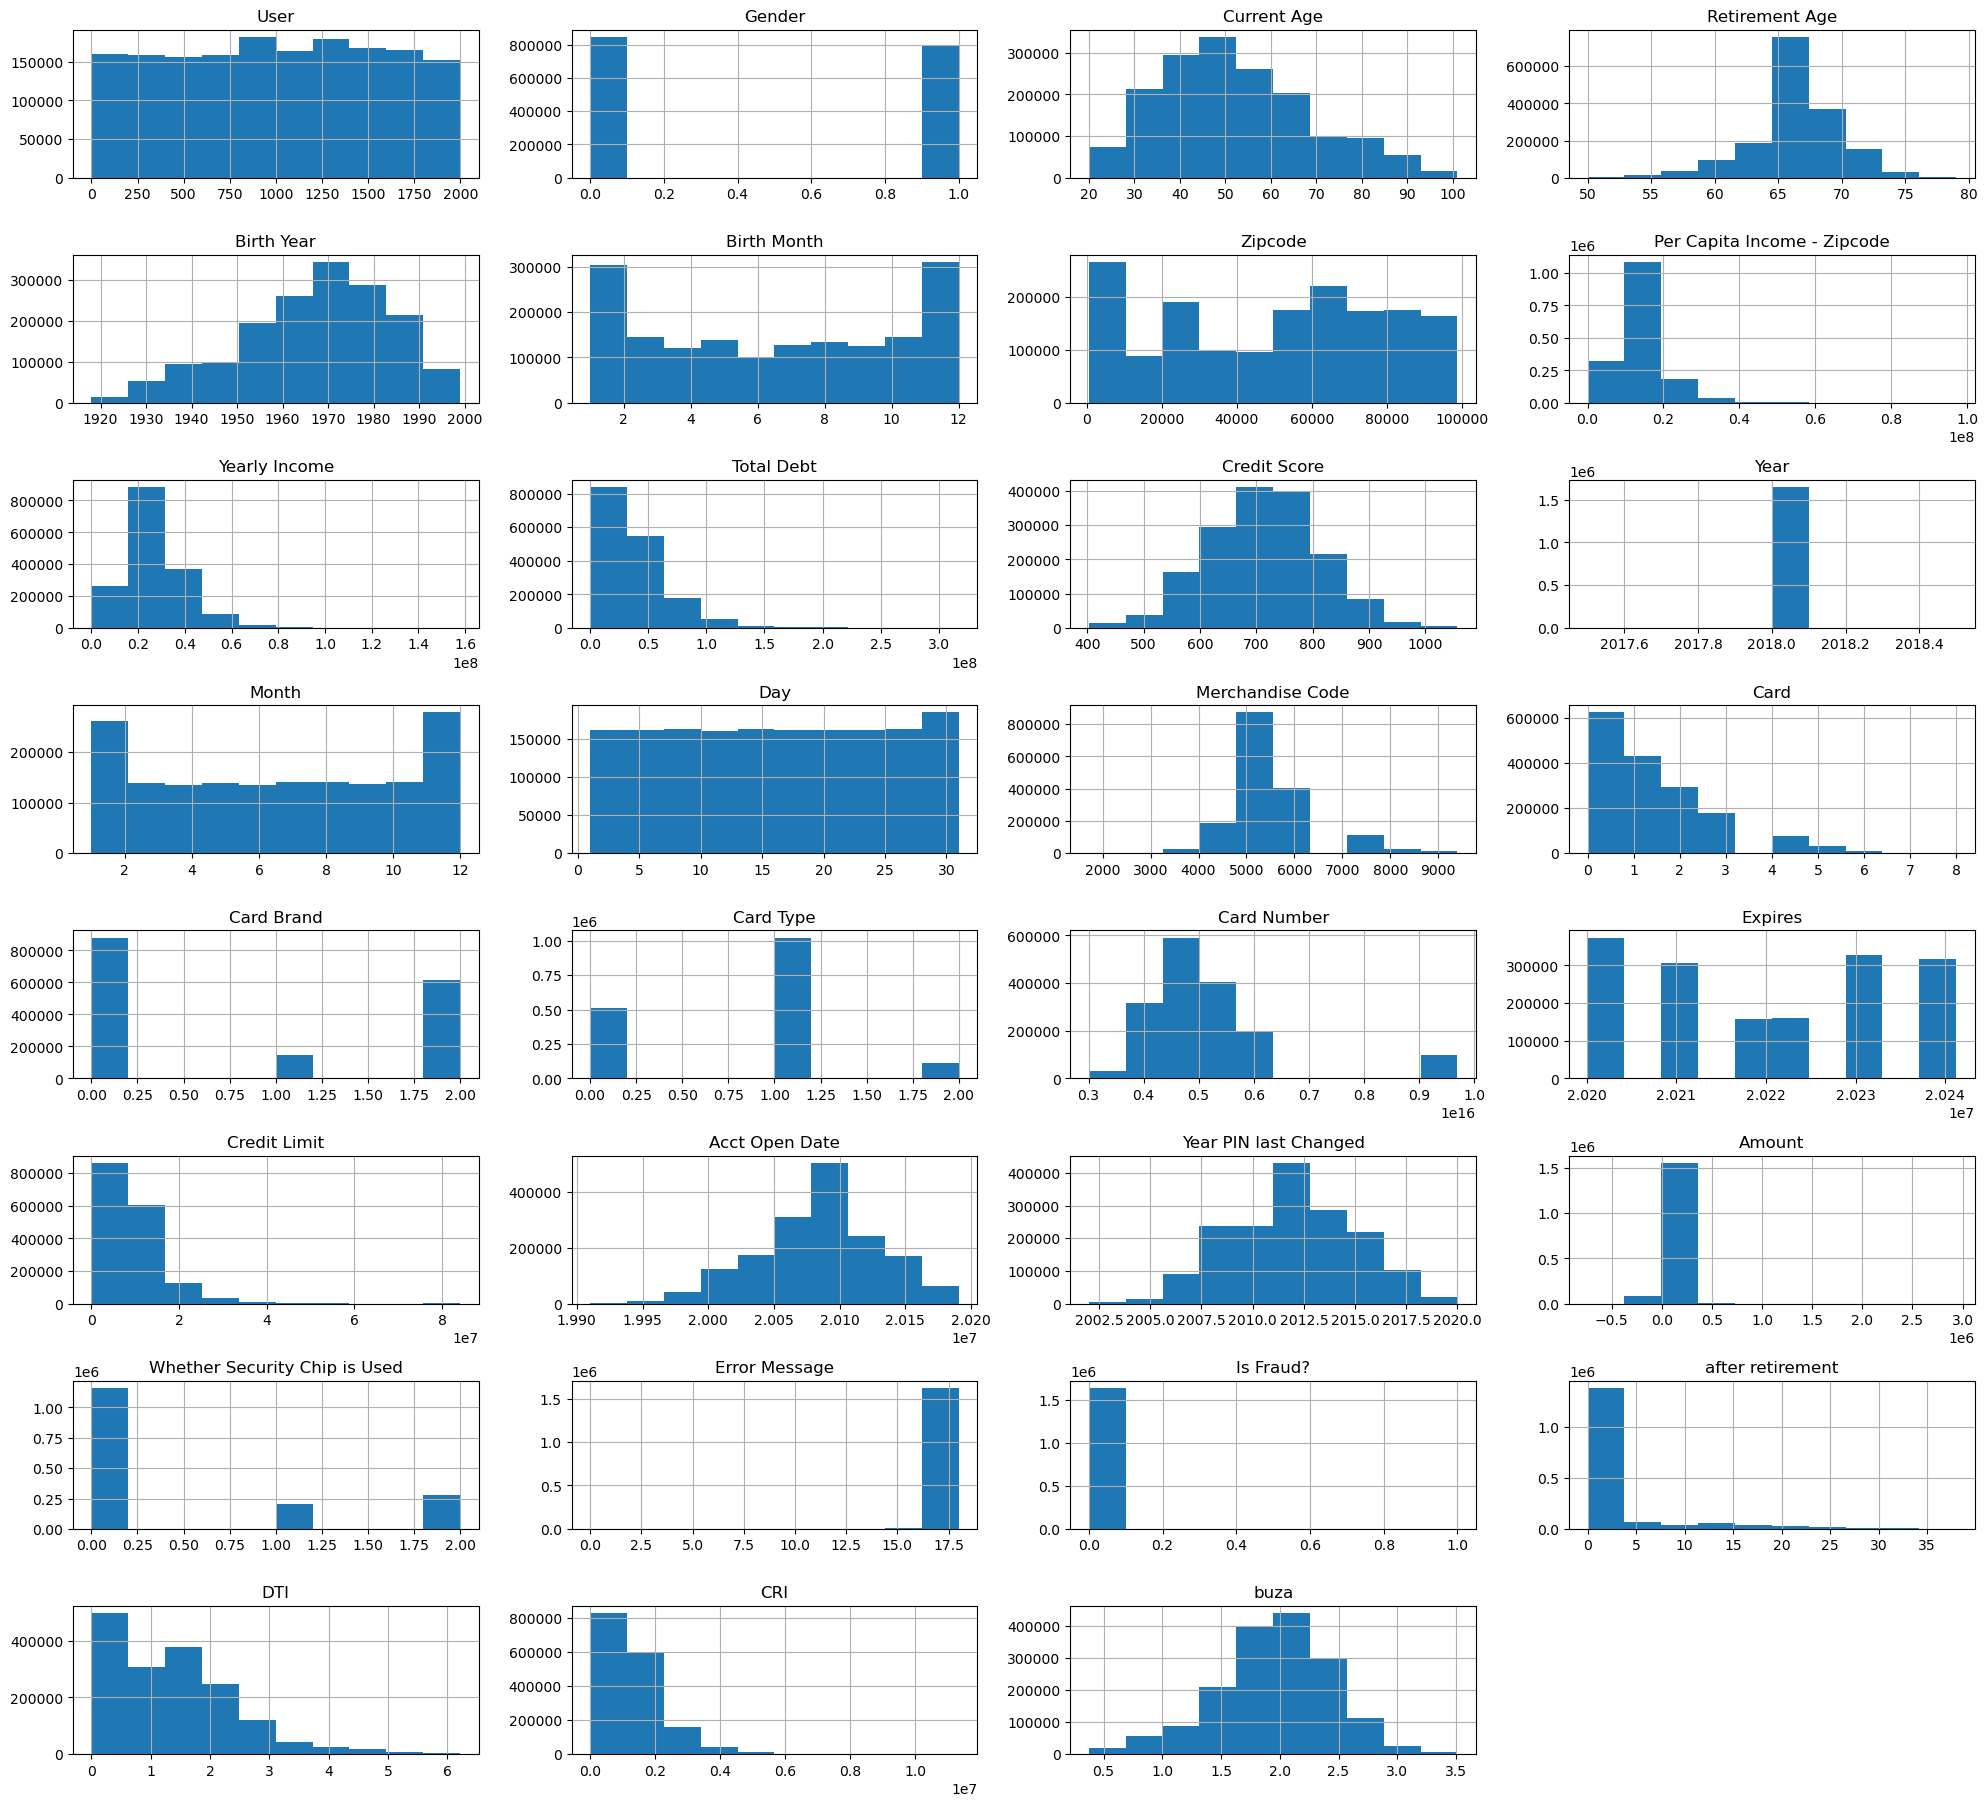

In [6]:
# 히스토그램 그리기, 한 줄에 4개씩 배치
train_data.hist(figsize=(20, 20), layout=(int(len(train_data.columns) / 4) + 1, 4))
plt.tight_layout()
plt.show()

#### Train / Test Dataset 분리하기

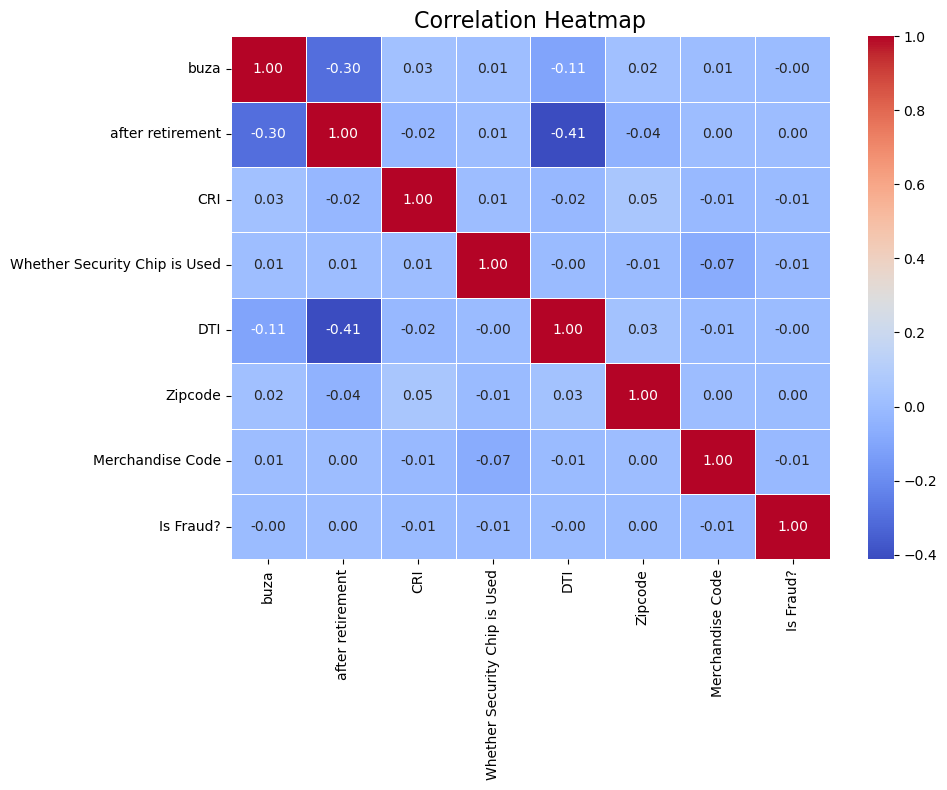

In [8]:
# EDA 직후 columns selected_columns=['Current Age','Card','Whether Security Chip is Used','Yearly Income','Zipcode','Merchandise Code','Is Fraud?']
selected_columns=['buza','after retirement','CRI','Whether Security Chip is Used','DTI','Zipcode','Merchandise Code','Is Fraud?']
td = train_data[selected_columns]

td = td.dropna()

X = td.drop(columns=['Is Fraud?'])
y = td['Is Fraud?']

correlation_write(td)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



### Logistic Regression

Accuracy: 0.5392
              precision    recall  f1-score   support

           0       1.00      0.54      0.70    492750
           1       0.00      0.63      0.00       681

    accuracy                           0.54    493431
   macro avg       0.50      0.58      0.35    493431
weighted avg       1.00      0.54      0.70    493431



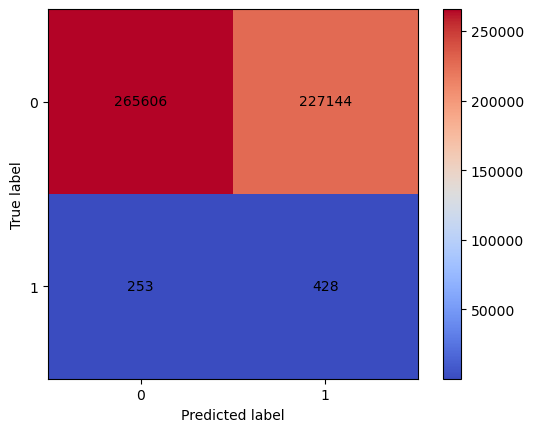

In [9]:

model = LogisticRegression(penalty='l2',fit_intercept=False,class_weight='balanced',max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# 분류 리포트 출력 (Precision, Recall, F1-score 등)
print(classification_report(y_test, y_pred))

cm=confusion_matrix(y_test,y_pred)
matrix=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
matrix.plot(cmap='coolwarm')
for text in matrix.text_.ravel():
    text.set_color("black")
plt.grid(False)
plt.show()

### Random Forest

In [32]:
rf=RandomForestClassifier(class_weight='balanced',random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Accuracy: 0.9904
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    492727
           1       0.06      0.41      0.11       704

    accuracy                           0.99    493431
   macro avg       0.53      0.70      0.55    493431
weighted avg       1.00      0.99      0.99    493431



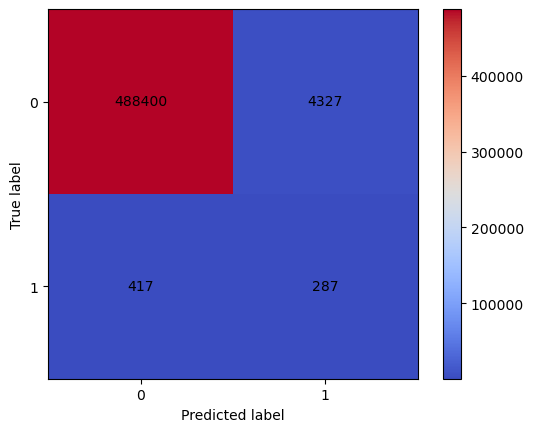

In [33]:
rf_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, rf_pred)
print(f'Accuracy: {accuracy:.4f}')

# 분류 리포트 출력 (Precision, Recall, F1-score 등)
print(classification_report(y_test, rf_pred))

cm=confusion_matrix(y_test,rf_pred)
matrix=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
matrix.plot(cmap='coolwarm')
for text in matrix.text_.ravel():
    text.set_color("black")
plt.grid(False)
plt.show()

In [34]:
#Random Forest 결과물 -> Feature Importance

importances = rf.feature_importances_
# 특성 이름과 중요도를 함께 보기 (X_train이 DataFrame일 때)
feature_names = X_train.columns  # X_train이 Pandas DataFrame일 때
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 중요도가 높은 순서대로 정렬
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

                         Feature  Importance
6               Merchandise Code    0.278015
2                            CRI    0.186050
5                        Zipcode    0.155679
0                           buza    0.152099
4                            DTI    0.143444
1               after retirement    0.042770
3  Whether Security Chip is Used    0.041943


#### SVM(Support Vector Machine)

Accuracy: 0.5070
              precision    recall  f1-score   support

           0       1.00      0.51      0.67    492727
           1       0.00      0.68      0.00       704

    accuracy                           0.51    493431
   macro avg       0.50      0.59      0.34    493431
weighted avg       1.00      0.51      0.67    493431



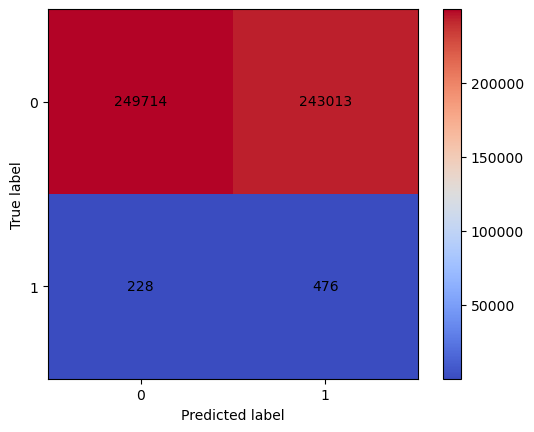

In [35]:
scaler = StandardScaler()
svm = make_pipeline(StandardScaler(),LinearSVC(penalty='l1',class_weight='balanced'))
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# 분류 리포트 출력 (Precision, Recall, F1-score 등)
print(classification_report(y_test, y_pred))

cm=confusion_matrix(y_test,y_pred)
matrix=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
matrix.plot(cmap='coolwarm')
for text in matrix.text_.ravel():
    text.set_color("black")
plt.grid(False)
plt.show()